In [47]:
import random
import json
import re

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix

random.seed(6)
np.random.seed(6)


# Experiment 7 - Llama3.1 8b as a judge

In this experiment I implement the technique `LLM as judge` used in the paper `How good is my MML?` as evaluaiton metric for the correctness of the answers given by a model. The method 
consists of using a LLM to evaluate the correctness of the answers given by another model. The LLM acts as a judge by comparing the predicted answer with the ground truth answer and providing a score between 0 and 5, expressing the confidence in the answer. The judge also provides a reason for the score.


**Parameters:**
- model: llama3.1 8b
- system prompt: LLM_judge_system.txt
- temperature: 0.1
- sampling method: (default) top-p (p=0.9)


Let's load the ground truth from the `STAR_QA_question_and_stsg_val.json` file where we extracted QA and spatio-temporal scene graphs

In [48]:
ground_truth = []

with open('../data/datasets/STAR_QA_and_stsg_val.json') as f:
    data = json.load(f)
    ground_truth = [{
        'id': sample['question_id'],
        'question': sample['question'],
        'choices': sample['choices'],
        'num': sample['answer'],
        'text': sample['choices'][str(sample['answer'])]
    } for sample in data]


# we keep num as str so we can directrly access choices dictionaries
gt_df = pd.DataFrame(ground_truth).astype({'id': 'string', 'num': 'string', 'text': 'string'})
gt_df.set_index('id', inplace=True)
gt_df


,question,choices,num,text
id,,,,
Interaction_T1_13,Which object was tidied up by the person?,"{'0': 'The closet/cabinet.', '1': 'The blanket...",2,The clothes.
Interaction_T1_14,Which object was tidied up by the person?,"{'0': 'The blanket.', '1': 'The table.', '2': ...",2,The clothes.
Interaction_T1_31,Which object was thrown by the person?,"{'0': 'The pillow.', '1': 'The bag.', '2': 'Th...",2,The clothes.
Interaction_T1_32,Which object was put down by the person?,"{'0': 'The food.', '1': 'The shoe.', '2': 'The...",1,The shoe.
Interaction_T1_40,Which object was tidied up by the person?,"{'0': 'The broom.', '1': 'The closet/cabinet.'...",1,The closet/cabinet.
...,...,...,...,...
Feasibility_T6_1453,What is the person able to do after taking the...,"{'0': 'Wash the table.', '1': 'Take the box.',...",0,Wash the table.
Feasibility_T6_1454,What is the person able to do after walking th...,"{'0': 'Take the towel.', '1': 'Throw the bag.'...",0,Take the towel.
Feasibility_T6_1455,What is the person able to do after walking th...,"{'0': 'Throw the bag.', '1': 'Wash the table.'...",1,Wash the table.


In [49]:
predictions = []
with open('../outputs/mcq_reasoning_llama3.2_20250210_20:17:23.jsonl') as f:
    predictions = [json.loads(line) for line in f.readlines()]

# transforming the id key from `qid` to `id` for consistency and `response` to `answer`
predictions_df = pd.DataFrame(predictions, dtype='string').rename(columns={'qid':'id'})
predictions_df.set_index('id', inplace=True)
predictions_df

a_word = rf"\b[\w/]+\b"
ans_regex_pattern = rf'A:\s*(?:\d\.)?\s*({a_word}(?:\s{a_word}){{,9}}\.)'
#ans_regex_pattern = r'<Final answer>\s*A:\s*(?:\d\.)?\s*((?:\w+(?:\s|\/)?){,10}\.)\s*(?:</Final answer>)?'

ans_df = predictions_df['response'].str.extract(ans_regex_pattern)
ans_df.rename(columns={0: 'text'}, inplace=True)

ans_df['text'] = ans_df['text'].str.strip()
contains_ans_mask = ans_df['text'].notna()
ans_df = ans_df[contains_ans_mask]
ans_df

print(f"Answer following the template: {contains_ans_mask.value_counts()[True]}\n"
      f"{contains_ans_mask.value_counts()[True]/predictions_df.size:.2%} of the total")

print(f"\nOnly {contains_ans_mask.value_counts()[False]} samples do not contain the answer in the response with the specified format")


Answer following the template: 6902
97.24% of the total

Only 196 samples do not contain the answer in the response with the specified format


In [50]:
t1 = predictions_df[contains_ans_mask]['response'].apply(lambda x: re.findall(ans_regex_pattern, x))

len_series = t1.apply(len)


In [51]:
len_series.value_counts()


1    6507
2     367
5       8
4       8
3       5
8       3
6       2
7       2
Name: response, dtype: int64

In [52]:
contains_ans_mask.sum()


6902

In [53]:
ans_df = \
    predictions_df[contains_ans_mask]['response'] \
    .apply(lambda x: re.findall(ans_regex_pattern, x)[-1]) \
    .to_frame(name='text')

ans_df


,text
id,
Interaction_T1_13,The clothes.
Interaction_T1_14,The clothes.
Interaction_T1_32,The shoe.
Interaction_T1_40,The blanket.
Interaction_T1_43,The clothes.
...,...
Feasibility_T6_1453,Wash the table.
Feasibility_T6_1454,Wipe the table.
Feasibility_T6_1455,Take the shoe.


In [54]:
exact_match_pred = (gt_df[contains_ans_mask]['text'] == ans_df['text'])
exact_match_pred = exact_match_pred[contains_ans_mask]
exact_match_pred.shape


(6902,)

## Loading the the Judge evaluation

Now we load the judge evaluation on the responses of the perdictor model. The set of responses are saved in two different files. `llama8b_as_judge_wrong.jsonl` contains the responses that were classified as incorrect by the method with the method extraction, `llama8b_as_judge_correct.jsonl` contains the responses classified as correct.  
These two files contains only the responses for which it was able to extract an answer with the regex.

In [55]:
# Load the scores for the wrong answers
predictions_incorrect = []
with open('../outputs/responses_llama3.1:8b_20250306_16:09:19.jsonl', 'r', encoding='utf-8') as f:
    predictions_incorrect = [json.loads(line) for line in f.readlines()]

# Load the scores for the correct answers
predictions_correct = []
with open('../outputs/responses_llama3.1:8b_20250306_14:03:29.jsonl', 'r', encoding='utf-8') as f:
    predictions_correct = [json.loads(line) for line in f.readlines()]

predictions = predictions_incorrect + predictions_correct

# Extract pred, score and reason from response dictionary into separate columns
judge_pred_df = pd.DataFrame(predictions).rename(columns={'qid':'id'})
judge_pred_df.set_index('id', inplace=True)
judge_pred_df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 6900 entries, Interaction_T1_40 to Feasibility_T6_1468
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   response  6900 non-null   object
dtypes: object(1)
memory usage: 107.8+ KB


## Handle formatting issues

In [56]:
# Replace new line (lead to EOF Errors) with whitespace
judge_pred_df['response'] = \
    judge_pred_df['response'].str.replace('\n+', ' ', regex=True)


Response 'Interaction_T1_881' is malformed:

Let's keep only the relevant part:

In [57]:
relevant_part = re.search(r"\{.*\}", judge_pred_df.loc['Interaction_T1_881']['response']).group(0)
judge_pred_df.loc['Interaction_T1_881']['response'] = relevant_part
judge_pred_df.loc['Interaction_T1_881']['response'] 


'{\'reason\': "Upon closer inspection, there is no instance where a person is holding any of these objects except for the pillow.",  \'pred\': \'correct\',  \'score\': 5}'

In [58]:
relevant_part = re.search(r"\{.*\}", judge_pred_df.loc['Interaction_T1_3788']['response']).group(0)
judge_pred_df.loc['Interaction_T1_3788']['response'] = relevant_part
judge_pred_df.loc['Interaction_T1_3788']['response'] 


'{\'reason\': "The correct answer is therefore A: 3. The box.", \'pred\': \'incorrect\', \'score\': 0}'

In [59]:
relevant_part = re.search(r"\{.*\}", judge_pred_df.loc['Interaction_T1_4998']['response']).group(0)
judge_pred_df.loc['Interaction_T1_4998']['response'] = relevant_part
judge_pred_df.loc['Interaction_T1_4998']['response'] 


'{\'reason\': "Upon closer inspection, we notice that the person is sometimes holding a phone/camera, which could be considered as closing or covering an object.", \'pred\': \'correct\', \'score\': 4}'

In [60]:
# sometimes the model writes outside the {...} bounderies
# let's keep only the relevant part
judge_pred_df['response'] = \
    judge_pred_df.apply(
        func=lambda row: re.sub(
            r"(\{.*\})(.*)", 
             r"\1", 
            row['response']),
        axis=1
        )

# some times the model starts the answer with \" but then terminates it with \'
judge_pred_df['response'] = \
    judge_pred_df.apply(
        func=lambda row: re.sub(
            r"(\'reason\':.*)\',(?= \'pred\':)", 
            lambda matchobj: matchobj.group(1)+ "\",", 
            row['response']),
        axis=1
        )

# some times it misses the , after the "
judge_pred_df['response'] = \
    judge_pred_df.apply(
        func=lambda row: re.sub(
            r"(\'reason\':.*\")\s+(?= \'pred\':)", 
            lambda matchobj: matchobj.group(1)+ ", ", 
            row['response']),
        axis=1
        )

# ------------------ Removing inner double quotes --------------------
# It may happen that the text may contain inner double quotes before the
# attribute end. This will cause the parser to termiate early and spout
# errors for the remaining text. With this snippet we replace those inner
# double quotes with single quotes.
#  
# we first match the text of the reason paramter inside the double quotes
# then we escape/replace all the double quotes inside the text
inside_doublequotes = r"(?<=\'reason\': \")(.*)(?=\"(?:,|}))"

judge_pred_df['response'] = \
    judge_pred_df.apply(
        func=lambda row: re.sub(
            inside_doublequotes, 
            lambda matchobj: matchobj.group(0).replace('\"', ''), 
            row['response']),
        axis=1
        )

judge_pred_df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 6900 entries, Interaction_T1_40 to Feasibility_T6_1468
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   response  6900 non-null   object
dtypes: object(1)
memory usage: 365.9+ KB


## Extract answers

In [61]:
# Extract pred, score and reason from response dictionary into separate columns
judge_pred_df['pred'] = \
    judge_pred_df['response'] \
    .apply(lambda x: eval(x)['pred']) \
    .astype('string') 

judge_pred_df['score'] = \
    judge_pred_df['response'] \
    .apply(lambda x: int(eval(x)['score'])) \
    .astype('int32')

judge_pred_df['reason'] = \
    judge_pred_df['response'] \
    .apply(lambda x: eval(x)['reason']) \
    .astype('string')

judge_pred_df.drop('response', axis=1, inplace=True)
judge_pred_df


,pred,score,reason
id,,,
Interaction_T1_40,incorrect,2,The model's final answer is based on the infer...
Interaction_T1_71,incorrect,2,The model's final answer is based on the analy...
Interaction_T1_78,incorrect,2,The model's reasoning about the laptop being o...
Interaction_T1_95,incorrect,2,The model's reasoning is based on analyzing Sc...
Interaction_T1_100,incorrect,2,The model's final answer is based on the analy...
...,...,...,...
Feasibility_T6_1428,correct,5,The model's final answer is based on the analy...
Feasibility_T6_1448,correct,5,The model's final answer is based on the analy...
Feasibility_T6_1449,correct,5,The model's final answer is correct because it...


In [62]:
judge_pred_df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 6900 entries, Interaction_T1_40 to Feasibility_T6_1468
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   pred    6900 non-null   string
 1   score   6900 non-null   int32 
 2   reason  6900 non-null   string
dtypes: int32(1), string(2)
memory usage: 446.7+ KB


In [63]:
judge_pred_df


,pred,score,reason
id,,,
Interaction_T1_40,incorrect,2,The model's final answer is based on the infer...
Interaction_T1_71,incorrect,2,The model's final answer is based on the analy...
Interaction_T1_78,incorrect,2,The model's reasoning about the laptop being o...
Interaction_T1_95,incorrect,2,The model's reasoning is based on analyzing Sc...
Interaction_T1_100,incorrect,2,The model's final answer is based on the analy...
...,...,...,...
Feasibility_T6_1428,correct,5,The model's final answer is based on the analy...
Feasibility_T6_1448,correct,5,The model's final answer is based on the analy...
Feasibility_T6_1449,correct,5,The model's final answer is correct because it...


In [64]:
judge_pred_df.shape


(6900, 3)

In [65]:
# reindex exact_match to mirror the index of judge_pred_df
#
# This operation is need for two reasons:
# 1. have an aligned index
# 2. remove from exact_match_pred those answers that are not present in judge_pred

exact_match_pred = exact_match_pred.reindex(judge_pred_df.index)
exact_match_pred


id
Interaction_T1_40      False
Interaction_T1_71      False
Interaction_T1_78      False
Interaction_T1_95      False
Interaction_T1_100     False
                       ...  
Feasibility_T6_1428     True
Feasibility_T6_1448     True
Feasibility_T6_1449     True
Feasibility_T6_1453     True
Feasibility_T6_1468     True
Name: text, Length: 6900, dtype: boolean

## Evlaution on the answers originally marked as wrong

In [66]:
pred_percentages = judge_pred_df[~exact_match_pred]['pred'].value_counts(normalize=True) * 100

print("\nPredictions:")
print("-" * 30)
print(f"{'incorrect':10}: {pred_percentages['incorrect']:6.2f}%\n"
      f"{'correct':10}: {pred_percentages['correct']:6.2f}%")
print("-" * 30)



Predictions:
------------------------------
incorrect :  95.67%
correct   :   4.33%
------------------------------


An interesting metric, on 95% of the cases the model is concording with the deterministic classification of the answer regex extraction method

Let's analyze some of the answers

---
Let's inspect more samples...

In [67]:
judged_correct_mask = (judge_pred_df[~exact_match_pred]['pred'] == 'correct')
idx = random.choice(judged_correct_mask[judged_correct_mask].index)


print(f"Index: {idx}")
print(f"Question: {gt_df.loc[idx]['question']}")
print(f"Ground truth answer: {gt_df.loc[idx]['text']}")
print(f"Extracted answer: {ans_df.loc[idx]['text']}")
print(f"\nOriginal answer:\n\n{predictions_df.loc[idx]['response']}")
print(f"\nJudge evlauation:\n"
      f" - verdict: {judge_pred_df.loc[idx]['pred']}\n"
      f" - score: {judge_pred_df.loc[idx]['score']}\n"
      f" - reason: {judge_pred_df.loc[idx]['reason']}\n")


Index: Prediction_T2_19
Question: What will the person do next with the closet/cabinet?
Ground truth answer: Close.
Extracted answer: Open.

Original answer:

<Reasoning>
To determine what the person will do next with the closet/cabinet, we need to analyze the sequence of events unfolding in the scene.
The first Scene-Graph shows the person holding a dish and standing next to the closet/cabinet. This suggests that they are about to put down the dish or perform some other action related to the closet/cabinet.
However, subsequent Scene-Graphs show the person moving away from the closet/cabinet, indicating that they have finished their current task with it.
The final Scene-Graph shows the person standing behind the closet/cabinet, which implies that they are now closing it.
Therefore, based on the sequence of events, it is most likely that the person will close the closet/cabinet next.

A: 3. Open.

Judge evlauation:
 - verdict: correct
 - score: 5
 - reason: The final Scene-Graph shows t

### Distribution of confidence score

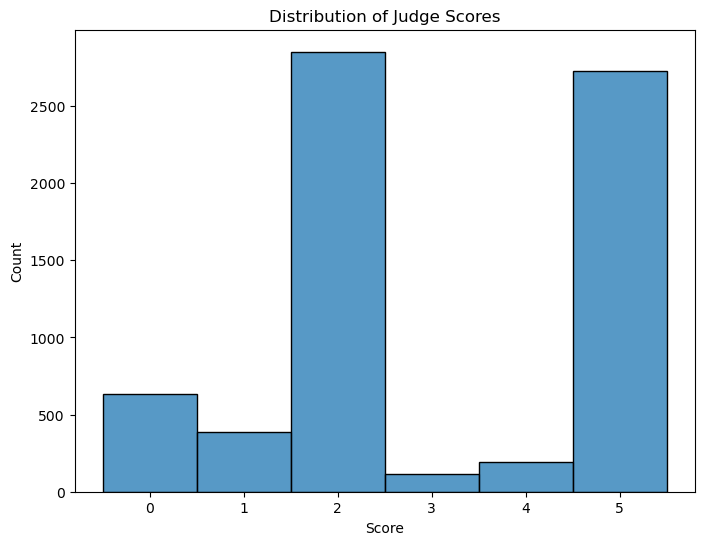

In [68]:
# Let's see the score distribution for all the predictions

plt.figure(figsize=(8, 6))
sns.histplot(data=judge_pred_df['score'], discrete=True)
plt.title('Distribution of Judge Scores')
plt.xlabel('Score')
plt.ylabel('Count')
plt.show()


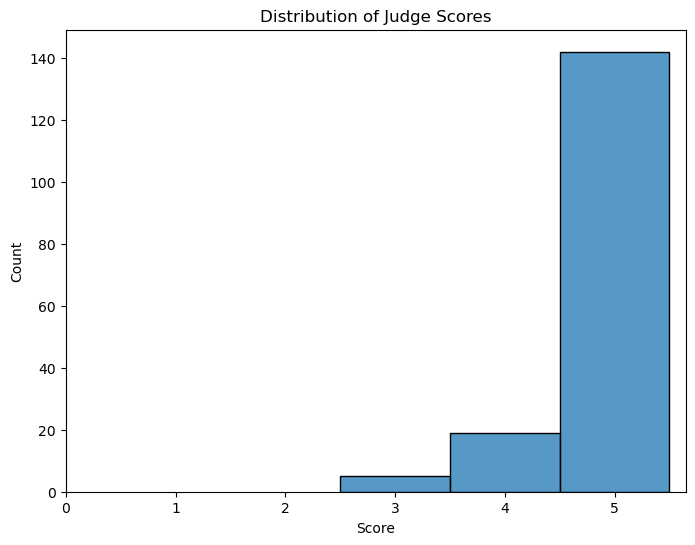

In [69]:
# Now the score distribution for the prediction which the judge considers as correct answer

plt.figure(figsize=(8, 6))
sns.histplot(data = \
             judge_pred_df \
             .loc[~exact_match_pred] \
             .loc[judged_correct_mask]['score'], discrete=True, bins=6)
plt.title('Distribution of Judge Scores for cases with prediction mismatch')
plt.xlabel('Score')
plt.ylabel('Count')
plt.xticks(range(6))
plt.show()


Not good. The LLM is very confident for these set of answers, even though we have just verified that not all them are consitent with the ground truth.

## Evaluation on the answers originally marked as correct

In [70]:
judge_pred_df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 6900 entries, Interaction_T1_40 to Feasibility_T6_1468
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   pred    6900 non-null   string
 1   score   6900 non-null   int32 
 2   reason  6900 non-null   string
dtypes: int32(1), string(2)
memory usage: 446.7+ KB


In [71]:
pred_percentages = judge_pred_df[exact_match_pred]['pred'].value_counts(normalize=True) * 100

print("\nPredictions:")
print("-" * 30)
print(f"{'incorrect':10}: {pred_percentages['incorrect']:6.2f}%\n"
      f"{'correct':10}: {pred_percentages['correct']:6.2f}%")
print("-" * 30)



Predictions:
------------------------------
incorrect :  10.20%
correct   :  89.80%
------------------------------


An interesting metric, on 95% of the cases the model is concording with the deterministic classification of the answer regex extraction method

Load the orignal model predictions to verify the judgement of the model.

In [72]:
judged_incorrect_mask = judge_pred_df[exact_match_pred]['pred'] == 'incorrect'

judge_pred_df[exact_match_pred][judged_incorrect_mask]


,pred,score,reason
id,,,
Interaction_T1_1561,incorrect,2,Given the context of the scene where the perso...
Interaction_T1_6589,incorrect,1,The model's final answer is based on the state...
Interaction_T4_1503,incorrect,2,The model's final answer is based on the follo...
Interaction_T4_3746,incorrect,2,The model's final answer was influenced by the...
Sequence_T2_2597,incorrect,1,"The model's final answer is A: 3. The floor., ..."
...,...,...,...
Feasibility_T6_645,incorrect,2,The model's final answer is based on the infer...
Feasibility_T6_1275,incorrect,2,The model's final answer is based on the infer...
Feasibility_T6_1298,incorrect,2,The model's final answer is based on the state...


Let's analyze some of the answers

### Distribution of confidence score

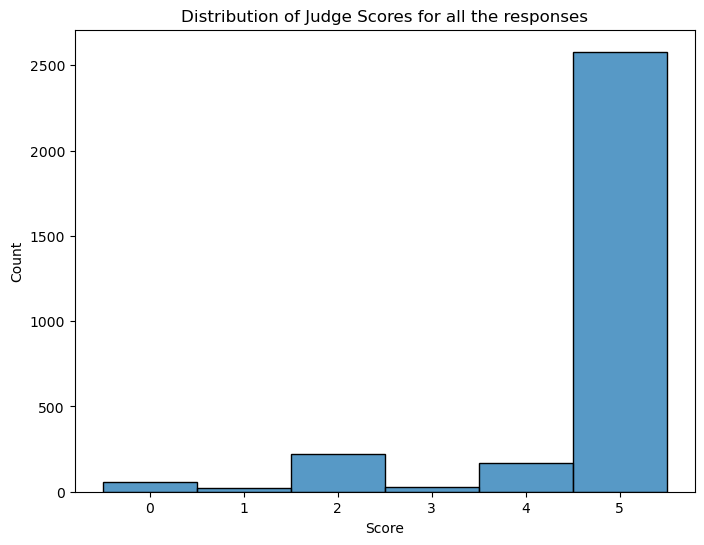

In [73]:
# Let's see the score distribution for all the predictions

plt.figure(figsize=(8, 6))
sns.histplot(data=judge_pred_df[exact_match_pred]['score'], discrete=True)
plt.title('Distribution of Judge Scores for all the responses')
plt.xlabel('Score')
plt.ylabel('Count')
plt.show()


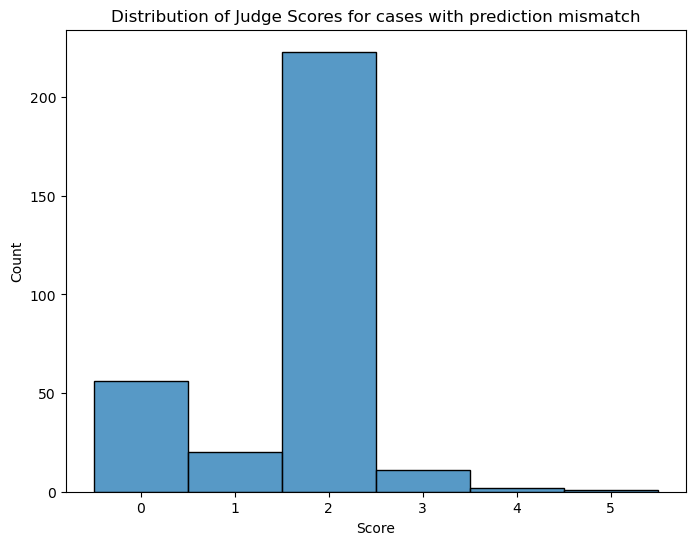

In [74]:
# Now the score distribution for the prediction which the judge considers as incorrect answers

plt.figure(figsize=(8, 6))
sns.histplot(data= \
             judge_pred_df \
             .loc[exact_match_pred]
             .loc[judged_incorrect_mask]['score'], discrete=True, bins=6)
plt.title('Distribution of Judge Scores for cases with prediction mismatch')
plt.xlabel('Score')
plt.ylabel('Count')
plt.xticks(range(6))
plt.show()


Let's check the mismatch cases where the Judge LLM is most confident (score > 2)

In [75]:
high_conf = judged_incorrect_mask[judge_pred_df['score'] > 2]
hig_conf_idxs = high_conf[high_conf].index
hig_conf_idxs


Index(['Interaction_T2_2974', 'Interaction_T2_5396', 'Interaction_T3_1450',
       'Sequence_T1_7505', 'Sequence_T3_1933', 'Sequence_T3_2267',
       'Sequence_T3_5576', 'Sequence_T4_1202', 'Sequence_T4_1918',
       'Sequence_T4_4903', 'Sequence_T6_198', 'Sequence_T6_1507',
       'Sequence_T6_4420', 'Feasibility_T2_1198'],
      dtype='object', name='id')

In [76]:
idx = 'Sequence_T1_1194'


print(f"Index: {idx}")
print(f"Question: {gt_df.loc[idx]['question']}")
print(f"Ground truth answer: {gt_df.loc[idx]['text']}")
print(f"Extracted answer: {ans_df.loc[idx]['text']}")
print(f"\nOriginal answer:\n\n{predictions_df.loc[idx]['response']}")
print(f"\nJudge evlauation:\n"
      f" - verdict: {judge_pred_df.loc[idx]['pred']}\n"
      f" - score: {judge_pred_df.loc[idx]['score']}\n"
      f" - reason: {judge_pred_df.loc[idx]['reason']}\n")


Index: Sequence_T1_1194
Question: Which object did the person take after they put down the cup/glass/bottle?
Ground truth answer: The sandwich.
Extracted answer: The sandwich.

Original answer:

<Reasoning>
The person is first seen holding a cup/glass/bottle, and then they put it down. After that, the person is not shown to be holding anything else in their hand. The alternatives given are the phone/camera, towel, paper/notebook, and sandwich. Since the person is no longer holding a cup/glass/bottle, we can rule out options 0 (phone/camera) and 1 (towel). Option 2 (paper/notebook) seems unlikely as there's no indication that the person picked up a notebook after putting down the cup/glass/bottle. This leaves us with option 3 (sandwich), which is plausible since the person could have put down the cup/glass/bottle and then picked up a sandwich.

However, we need to consider if the person actually took the sandwich or just had it in front of them. The scene graph does not explicitly show 

Let's check the other answers

In [77]:
idx = random.choice(judged_incorrect_mask[judged_incorrect_mask].index)

print(f"Index: {idx}")
print(f"Question: {gt_df.loc[idx]['question']}")
print(f"Ground truth answer: {gt_df.loc[idx]['text']}")
print(f"Extracted answer: {ans_df.loc[idx]['text']}")
print(f"\nOriginal answer:\n\n{predictions_df.loc[idx]['response']}")
print(f"\nJudge evlauation:\n"
      f" - verdict: {judge_pred_df.loc[idx]['pred']}\n"
      f" - score: {judge_pred_df.loc[idx]['score']}\n"
      f" - reason: {judge_pred_df.loc[idx]['reason']}\n")


Index: Interaction_T2_2083
Question: What did the person do with the towel?
Ground truth answer: Took.
Extracted answer: Took.

Original answer:

<Reasoning>
To determine what the person did with the towel, we need to analyze the Scene-Graphs in chronological order. 

The first Scene-Graph shows the person holding the towel and being in front of it, indicating that they are about to use or manipulate the towel.

The second Scene-Graph shows the person wiping a cup/glass/bottle, which is also in front of them. This suggests that the person is using the towel to clean something.

However, there is no Scene-Graph showing the person throwing, putting down, or taking the towel. 

Therefore, based on the available information, it can be inferred that the person used the towel to clean something, but the exact action (taking, putting down, throwing) cannot be determined with certainty.

A: 1. Took.

Judge evlauation:
 - verdict: incorrect
 - score: 2
 - reason: The model's final answer was in

---

Look at the following question.  
The answer does not follow from the reasoning but do the generated token contribute to determine the answer? In other words, even tough the reasoning is not sound do these token influence the probability distribution of choosing the answer?

In [78]:
idx = 'Sequence_T6_3033'

print(f"Index: {idx}")
print(f"Question: {gt_df.loc[idx]['question']}")
print(f"Ground truth answer: {gt_df.loc[idx]['text']}")
print(f"Extracted answer: {ans_df.loc[idx]['text']}")
print(f"\nOriginal answer:\n\n{predictions_df.loc[idx]['response']}")
print(f"\nJudge evlauation:\n"
      f" - verdict: {judge_pred_df.loc[idx]['pred']}\n"
      f" - score: {judge_pred_df.loc[idx]['score']}\n"
      f" - reason: {judge_pred_df.loc[idx]['reason']}\n")


Index: Sequence_T6_3033
Question: What did the person do to the cup/glass/bottle before putting down the dish?
Ground truth answer: Took.
Extracted answer: Took.

Original answer:

<Reasoning>
To answer this question, we need to analyze the sequence of events unfolding in the scene. The person is holding the dish and standing in front of it, indicating that they are about to put down the dish.

Looking at the Scene-Graphs, we can see that before putting down the dish, the person was holding a cup/glass/bottle. This suggests that the person had already picked up the cup/glass/bottle before picking up the dish.

However, we cannot determine what action the person did to the cup/glass/bottle (e.g., threw, took, washed, opened) from the given Scene-Graphs. The only information available is that the person was holding the cup/glass/bottle when they were holding the dish.

Therefore, based on the provided Scene-Graphs, we cannot determine what action the person did to the cup/glass/bottle be

## Evaluation on the entire dataset

In [79]:
judge_pred_correct_mask = (judge_pred_df['pred'] == 'correct')


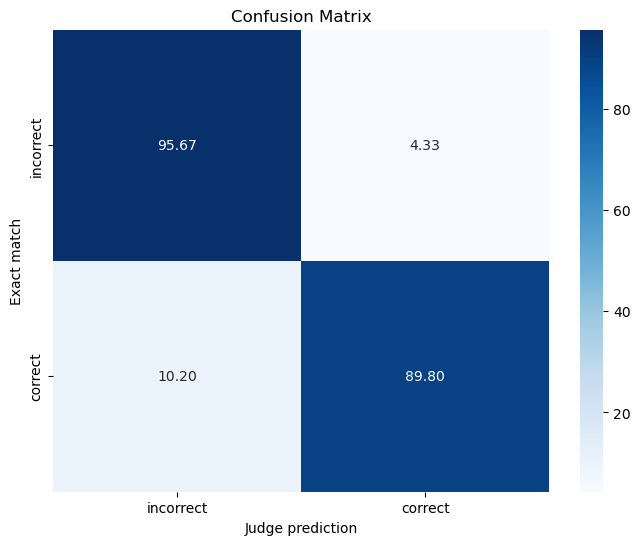

In [80]:
# Compute the confusion matrix

exact_match_labels = exact_match_pred.astype(int)
judge_pred_labels = judge_pred_correct_mask.astype(int)

cm = confusion_matrix(exact_match_labels, judge_pred_labels)

# Normalize the confusion matrix to percentage
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

# Plot the confusion matrix using Seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues', 
            xticklabels=['incorrect', 'correct'], 
            yticklabels=['incorrect', 'correct'])
plt.xlabel('Judge prediction')
plt.ylabel('Exact match')
plt.title('Agreement Matrix')
plt.show()


In [81]:
def print_acc(eval_df, acc_fn):
    print(f"{'Question type':<15}{'Total':^15}{'Accuracy':^10}\n")

    total = eval_df.index.str.startswith('Interaction').sum()
    acc = acc_fn(eval_df[eval_df.index.str.startswith('Interaction')])
    print(f"{'Interaction':<15}{total:^15}{acc:^10.2%}")

    total = eval_df.index.str.startswith('Sequence').sum()
    acc = acc_fn(eval_df[eval_df.index.str.startswith('Sequence')])
    print(f"{'Sequence':<15}{total:^15}{acc:^10.2%}")

    total = eval_df.index.str.startswith('Prediction').sum()
    acc = acc_fn(eval_df[eval_df.index.str.startswith('Prediction')])
    print(f"{'Prediction':<15}{total:^15}{acc:^10.2%}")

    total = eval_df.index.str.startswith('Feasibility').sum()
    acc = acc_fn(eval_df[eval_df.index.str.startswith('Feasibility')])
    print(f"{'Feasibility':<15}{total:^15}{acc:^10.2%}")


In [82]:
print('LLM as a Judge accuracy\n')
print_acc(judge_pred_correct_mask, lambda x: x.sum()/x.shape[0])


LLM as a Judge accuracy

Question type       Total      Accuracy 

Interaction         2308        41.90%  
Sequence            3485        42.90%  
Prediction           621        40.74%  
Feasibility          486        42.80%  


In [83]:
print('Answer extraction through regex accuracy\n')
print_acc(exact_match_pred, lambda x: x.sum()/x.shape[0])


Answer extraction through regex accuracy

Question type       Total      Accuracy 

Interaction         2308        44.58%  
Sequence            3485        44.68%  
Prediction           621        43.16%  
Feasibility          486        44.44%  


In [84]:
# Note: to access meta-llama you have to first accept the licence agreement
from transformers import AutoTokenizer
import os

hugg_key = os.environ['HUGGINGFACE_KEY']

tokenizer = AutoTokenizer.from_pretrained(
                'meta-llama/Llama-3.2-3B-Instruct', 
                token=hugg_key)


In [85]:
# 128000 : <|begin_of_text|>
# 128006 : <|start_header_id|>
# 128007 : <|end_header_id|>

a = tokenizer.encode("<|start_header_id|>system<|end_header_id|><|eom_id|>")
a


[128000, 128006, 9125, 128007, 128008]

In [86]:
# "chat_template": 
# "{{- bos_token }}\n{%- if custom_tools is defined %}\n    {%- set tools = custom_tools %}\n{%- endif %}\n{%- if not tools_in_user_message is defined %}\n    {%- set tools_in_user_message = true %}\n{%- endif %}\n{%- if not date_string is defined %}\n    {%- if strftime_now is defined %}\n        {%- set date_string = strftime_now(\"%d %b %Y\") %}\n    {%- else %}\n        {%- set date_string = \"26 Jul 2024\" %}\n    {%- endif %}\n{%- endif %}\n{%- if not tools is defined %}\n    {%- set tools = none %}\n{%- endif %}\n\n{#- This block extracts the system message, so we can slot it into the right place. #}\n{%- if messages[0]['role'] == 'system' %}\n    {%- set system_message = messages[0]['content']|trim %}\n    {%- set messages = messages[1:] %}\n{%- else %}\n    {%- set system_message = \"\" %}\n{%- endif %}\n\n{#- System message #}\n{{- \"<|start_header_id|>system<|end_header_id|>\\n\\n\" }}\n{%- if tools is not none %}\n    {{- \"Environment: ipython\\n\" }}\n{%- endif %}\n{{- \"Cutting Knowledge Date: December 2023\\n\" }}\n{{- \"Today Date: \" + date_string + \"\\n\\n\" }}\n{%- if tools is not none and not tools_in_user_message %}\n    {{- \"You have access to the following functions. To call a function, please respond with JSON for a function call.\" }}\n    {{- 'Respond in the format {\"name\": function name, \"parameters\": dictionary of argument name and its value}.' }}\n    {{- \"Do not use variables.\\n\\n\" }}\n    {%- for t in tools %}\n        {{- t | tojson(indent=4) }}\n        {{- \"\\n\\n\" }}\n    {%- endfor %}\n{%- endif %}\n{{- system_message }}\n{{- \"<|eot_id|>\" }}\n\n{#- Custom tools are passed in a user message with some extra guidance #}\n{%- if tools_in_user_message and not tools is none %}\n    {#- Extract the first user message so we can plug it in here #}\n    {%- if messages | length != 0 %}\n        {%- set first_user_message = messages[0]['content']|trim %}\n        {%- set messages = messages[1:] %}\n    {%- else %}\n        {{- raise_exception(\"Cannot put tools in the first user message when there's no first user message!\") }}\n{%- endif %}\n    {{- '<|start_header_id|>user<|end_header_id|>\\n\\n' -}}\n    {{- \"Given the following functions, please respond with a JSON for a function call \" }}\n    {{- \"with its proper arguments that best answers the given prompt.\\n\\n\" }}\n    {{- 'Respond in the format {\"name\": function name, \"parameters\": dictionary of argument name and its value}.' }}\n    {{- \"Do not use variables.\\n\\n\" }}\n    {%- for t in tools %}\n        {{- t | tojson(indent=4) }}\n        {{- \"\\n\\n\" }}\n    {%- endfor %}\n    {{- first_user_message + \"<|eot_id|>\"}}\n{%- endif %}\n\n{%- for message in messages %}\n    {%- if not (message.role == 'ipython' or message.role == 'tool' or 'tool_calls' in message) %}\n        {{- '<|start_header_id|>' + message['role'] + '<|end_header_id|>\\n\\n'+ message['content'] | trim + '<|eot_id|>' }}\n    {%- elif 'tool_calls' in message %}\n        {%- if not message.tool_calls|length == 1 %}\n            {{- raise_exception(\"This model only supports single tool-calls at once!\") }}\n        {%- endif %}\n        {%- set tool_call = message.tool_calls[0].function %}\n        {{- '<|start_header_id|>assistant<|end_header_id|>\\n\\n' -}}\n        {{- '{\"name\": \"' + tool_call.name + '\", ' }}\n        {{- '\"parameters\": ' }}\n        {{- tool_call.arguments | tojson }}\n        {{- \"}\" }}\n        {{- \"<|eot_id|>\" }}\n    {%- elif message.role == \"tool\" or message.role == \"ipython\" %}\n        {{- \"<|start_header_id|>ipython<|end_header_id|>\\n\\n\" }}\n        {%- if message.content is mapping or message.content is iterable %}\n            {{- message.content | tojson }}\n        {%- else %}\n            {{- message.content }}\n        {%- endif %}\n        {{- \"<|eot_id|>\" }}\n    {%- endif %}\n{%- endfor %}\n{%- if add_generation_prompt %}\n    {{- '<|start_header_id|>assistant<|end_header_id|>\\n\\n' }}\n{%- endif %}\n",
#   "clean_up_tokenization_spaces": true,


SyntaxError: invalid syntax (198944400.py, line 1)